In [1]:
# Settings for autoreloading.
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

# Get configuration data.
with open('config.yaml', 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)

# Directory related settings.
INPUT_DIR = config['directory']['input']
IMAGES_DIR = config['directory']['images']
OUT_DIR = config['directory']['out']

# Seed settings.
SEED = config['seed']

# Voxel grid settings.
MESH_GRID_SIZE = config['voxel_grid']['mesh_grid_size']
MIN_OCCUPANCY = config['voxel_grid']['min_occupancy']
X_MIN_VOXEL_COORD = config['voxel_grid']['x_min']
X_MAX_VOXEL_COORD = config['voxel_grid']['x_max']
Y_MIN_VOXEL_COORD = config['voxel_grid']['y_min']
Y_MAX_VOXEL_COORD = config['voxel_grid']['y_max']
Z_MIN_VOXEL_COORD = config['voxel_grid']['z_min']
Z_MAX_VOXEL_COORD = config['voxel_grid']['z_max']

In [3]:
from src.seeder import set_seed

# Set the random seed for reproducibility.
set_seed(SEED)

In [4]:
from src.data_loader import get_images,  get_perspective_projection_matrices

# Get the images of the dinosaur.
images = get_images(IMAGES_DIR)
# Get the perspective projection matrices.
ppms = get_perspective_projection_matrices(INPUT_DIR)

In [5]:
print('Shape of images:', images[0].shape)
print('Shape of perspective projection matrices:', ppms[0].shape)

Shape of images: (576, 720, 3)
Shape of perspective projection matrices: (3, 4)


In [6]:
from src.visualization import show_image_slider

show_image_slider(images, 'Dinosaur images')

Dinosaur images


interactive(children=(IntSlider(value=0, description='index', max=36), Output()), _dom_classes=('widget-intera…

In [7]:
from src.processing import get_cropped_images

# Crop images black borders
images_crop = get_cropped_images(images)

In [8]:
from src.visualization import show_image_slider

show_image_slider(images_crop, 'Cropped dinosaur images')

Cropped dinosaur images


interactive(children=(IntSlider(value=0, description='index', max=36), Output()), _dom_classes=('widget-intera…

In [9]:
from src.processing import get_gaussian_blurred_images

# Apply a Gaussian blur to the images.
images_blur = get_gaussian_blurred_images(images_crop)

In [10]:
from src.visualization import show_image_slider

show_image_slider(images_blur, 'Blurred dinosaur images')

Blurred dinosaur images


interactive(children=(IntSlider(value=0, description='index', max=36), Output()), _dom_classes=('widget-intera…

In [11]:
from src.processing import  get_color_space_converted_images

# Get the images in the LAB color space.
images_lab = get_color_space_converted_images(images_blur)

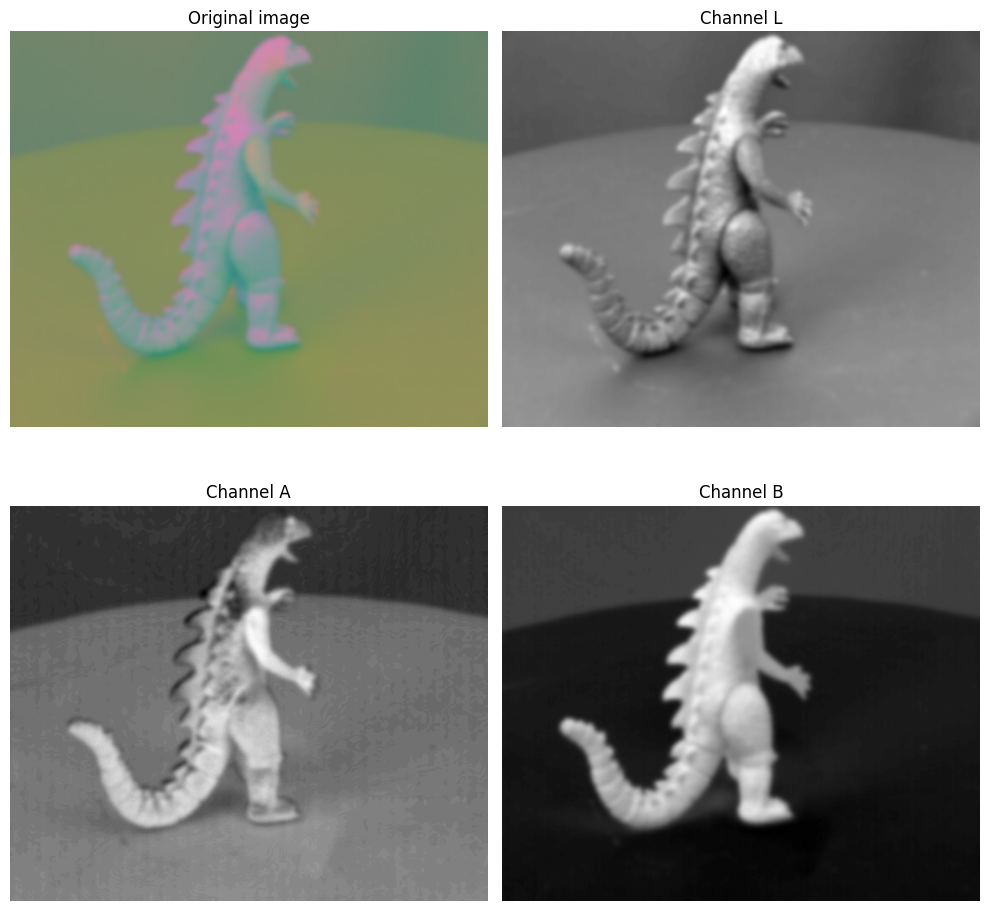

In [12]:
from src.visualization import show_image_channels

show_image_channels(images_lab[0], ['L', 'A', 'B'])

In [13]:
from src.processing import get_images_channel

# Get the B channel of the LAB color space.
images_b_channel = get_images_channel(images_lab, 2)

In [14]:
from src.visualization import show_image_slider

show_image_slider(
    images_b_channel,
    'Dinosaur images considering the V channel in the HSV color space')

Dinosaur images considering the V channel in the HSV color space


interactive(children=(IntSlider(value=0, description='index', max=36), Output()), _dom_classes=('widget-intera…

In [15]:
from src.processing import (get_otsu_threshold_masks,
                            get_images_to_original_dimensions)

# Get the masks of the images using the Otsu threshold.
images_masks = get_otsu_threshold_masks(images_b_channel)
# Resize the masks to the original dimensions to avoid mismatching
# between world and image coordinates.
images_masks = get_images_to_original_dimensions(images_masks)

In [16]:
from src.visualization import show_image_slider

show_image_slider(images_masks, 'Dinosaur images masks')

Dinosaur images masks


interactive(children=(IntSlider(value=0, description='index', max=36), Output()), _dom_classes=('widget-intera…

In [17]:
from src.processing import get_segmented_images

# Get the segmented images.
segmented_images = get_segmented_images(images, images_masks)

In [18]:
from src.visualization import show_image_slider

show_image_slider(segmented_images, 'Dinosaur images segmented by the masks')

Dinosaur images segmented by the masks


interactive(children=(IntSlider(value=0, description='index', max=36), Output()), _dom_classes=('widget-intera…

https://github.com/zinsmatt/SpaceCarving/blob/master/space_carving.py

https://github.com/zinsmatt/SpaceCarving/issues/7

In [20]:
from src.voxeling import get_voxel_grid_points

# Get the voxel grid points.
voxel_points = get_voxel_grid_points(
    MESH_GRID_SIZE,
    X_MIN_VOXEL_COORD,
    X_MAX_VOXEL_COORD,
    Y_MIN_VOXEL_COORD,
    Y_MAX_VOXEL_COORD,
    Z_MIN_VOXEL_COORD,
    Z_MAX_VOXEL_COORD)

In [21]:
print('Shape of the voxel points:', voxel_points.shape)

Shape of the voxel points: (4, 1728000)


In [22]:
from src.voxeling import get_images_with_voxel_grid

# Get the images with the voxel grid drawn over them.
images_with_voxels = get_images_with_voxel_grid(images, ppms, voxel_points)

In [23]:
from cv2 import COLOR_BGRA2RGBA
from src.visualization import show_image_slider

show_image_slider(
    images_with_voxels,
    'Voxel grid over the dinosaur images',
    color_conversion_code=COLOR_BGRA2RGBA)

Voxel grid over the dinosaur images


interactive(children=(IntSlider(value=0, description='index', max=35), Output()), _dom_classes=('widget-intera…

In [24]:
%%time

from src.voxeling import get_voxel_points_projection_is_in_images_mask

voxel_points_in_masks = get_voxel_points_projection_is_in_images_mask(
    images_masks,
    ppms,
    voxel_points)

CPU times: total: 5.88 s
Wall time: 5.56 s


In [25]:
print('Shape of the voxel points in mask:', voxel_points_in_masks.shape)

Shape of the voxel points in mask: (36, 1728000)


In [26]:
%%time

from src.voxeling import (get_voxel_points_occupancy,
                          get_voxel_points_by_minimum_occupancy)

# Get the occupancy of the voxel points.
occupancy = get_voxel_points_occupancy(voxel_points_in_masks)

# Get the voxel points with a minimum occupancy.
selected_voxel_points = get_voxel_points_by_minimum_occupancy(
    voxel_points,
    occupancy,
    MIN_OCCUPANCY)

CPU times: total: 93.8 ms
Wall time: 86 ms


In [27]:
print ('Shape of the selected voxel points:', selected_voxel_points.shape)

Shape of the selected voxel points: (4, 86604)


In [28]:
from src.voxeling import get_images_with_voxel_carving

images_3d_reconstruction = get_images_with_voxel_carving(
    images_masks,
    ppms,
    selected_voxel_points)

In [29]:
from cv2 import COLOR_BGRA2RGBA
from src.visualization import show_image_slider

show_image_slider(
    images_3d_reconstruction,
    '3D reconstruction of the dinosaur',
    color_conversion_code=COLOR_BGRA2RGBA)

3D reconstruction of the dinosaur


interactive(children=(IntSlider(value=0, description='index', max=35), Output()), _dom_classes=('widget-intera…

In [30]:
import os
from src.data_saver import (save_voxels_with_occupancy,
                            save_voxels_as_rectilinear_grid)

save_voxels_with_occupancy(
    os.path.join(OUT_DIR, 'shape.txt'),
    voxel_points,
    occupancy)

# Save as rectilinear grid (this enables paraview to display its 
# iso-volume as a mesh).
save_voxels_as_rectilinear_grid(
    os.path.join(OUT_DIR, 'shape.vtr'),
    voxel_points,
    occupancy,
    MESH_GRID_SIZE)